# Ejercicio 2 : Método de Levenberg-Marquardt

Primero, definimos las funciones de beale y ackley

In [243]:
using LinearAlgebra
using ForwardDiff
using Plots


# Función de Beale
function beale(x)
    a, b = x
    term1 = (1.5 - a + a*b)^2
    term2 = (2.25 - a + a*b^2)^2
    term3 = (2.625 - a + a*b^3)^2
    return term1 + term2 + term3
end

# Función de Ackley
function ackley(x)
    a, b = x
    term1 = -20 * exp(-0.2 * sqrt(0.5*(a^2 + b^2)))
    term2 = -exp(0.5*(cos(2π*a) + cos(2π*b)))
    return term1 + term2 + exp(1) + 20
end


ackley (generic function with 1 method)

Definimos la función de *levenberg_marquardt()*. La misma toma de input la función a maximizar y el punto inicial. Devuelve el x* encontrado y la trayectoria de los valores de f(x) a medida que avanzaba el algoritmo.

In [244]:
# Método de Levenberg-Marquardt
function levenberg_marquardt(f, x0; max_iter=1000, tol=1e-6, ε0=1e-3)
    x = copy(x0)
    history = [f(x)]
    
    for k in 1:max_iter
        g = ForwardDiff.gradient(f, x)
        H = ForwardDiff.hessian(f, x)
        
        # Calcular µk como el mínimo autovalor + ε0
        λ_min = minimum(eigvals(H))
        μk = λ_min < 0 ? -λ_min + ε0 : ε0  ### Si no hay autovalores negativos, definimos que mu_k = e0
        
        # Resolver (H + μkI)d = -g
        d = -(H + μk * Matrix(I, size(H, 1), size(H, 1))) \ g ## \ resuelve sistemas lineales
        
        x_new = x + d
        push!(history, f(x_new))
        
        # Criterio de parada en función de x y del gradiente de f (les ponemos una tolerancia tol)
        if norm(x_new - x) < tol && norm(g) < tol
            x = x_new
            break
        end
        
        x = x_new

    end
    
    return x, history
end

levenberg_marquardt (generic function with 1 method)

Probamos el algoritmo con puntos iniciales $[2,0]$ para Beale y $[1,1]$ para Ackley 

In [245]:

# Puntos iniciales
x0_beale = [2,0]  # Punto inicial para Beale
x0_ackley = [1,1] # Punto inicial para Ackley

# Aplicar el método
x_opt_beale, hist_beale = levenberg_marquardt(beale, x0_beale)
x_opt_ackley, hist_ackley = levenberg_marquardt(ackley, x0_ackley)

([0.9684776587077252, 0.9684776587077252], [3.6253849384403622, 3.5744848719351943, 3.574451877401483, 3.5744518772576797, 3.5744518772576797])

Observemos que en el caso de Beale encuentra $[2.999999999985283, 0.4999999999963266]$, que es muy cercano al mínimo global $[3,0.5]$. Sin embargo, en Ackley, encuentra el punto $[0.96,0.96]$. Esto podría ser un mínimo local. Más adelante lo analizaremos.

In [246]:
# Resultados
println("Función de Beale:")
println("Mínimo encontrado: ", x_opt_beale)
println("Valor en el mínimo: ", beale(x_opt_beale))
println("\nFunción de Ackley:")
println("Mínimo encontrado: ", x_opt_ackley)
println("Valor en el mínimo: ", ackley(x_opt_ackley))

Función de Beale:
Mínimo encontrado: [2.999999999985283, 0.4999999999963266]
Valor en el mínimo: 3.468092815687228e-23

Función de Ackley:
Mínimo encontrado: [0.9684776587077252, 0.9684776587077252]
Valor en el mínimo: 3.5744518772576797


Grafiquemos la convergencia de la función de Beale. Observemos que es estrictamente decreciente y la mayoría del descenso se da en el primer paso.

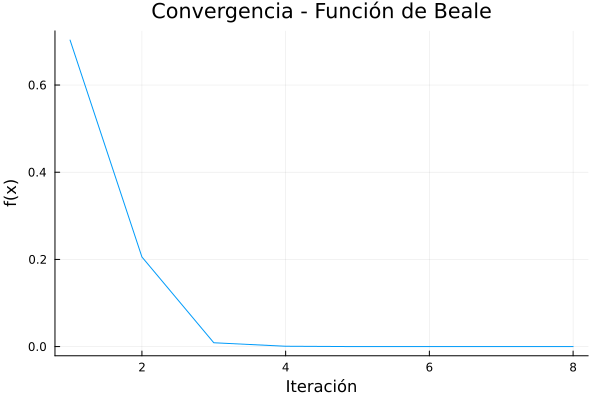

In [247]:
# Gráficos de convergencia
p1 = plot(hist_beale, title="Convergencia - Función de Beale", xlabel="Iteración", ylabel="f(x)", legend=false)

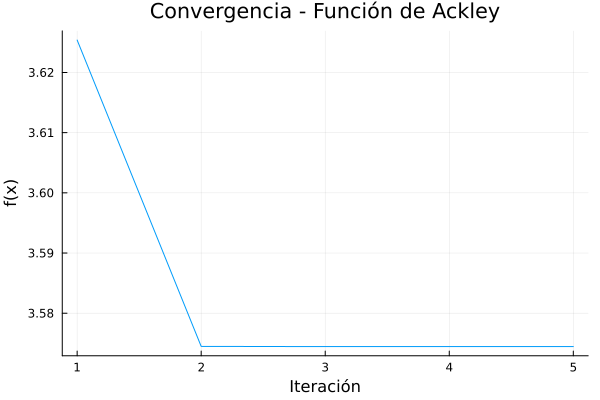

In [248]:
p2 = plot(hist_ackley, title="Convergencia - Función de Ackley", xlabel="Iteración", ylabel="f(x)", legend=false)


Podríamos pensar que lo que estamos encontrando en Ackley es un mínimo local. Pero evaluando en el punto, podemos ver que evidentemente parece tratarse de un mínimo local.

In [249]:
ForwardDiff.gradient(ackley,x_opt_ackley)

2-element Vector{Float64}:
 3.419486915845482e-14
 3.419486915845482e-14

Fijemonos qué ocurre si inicializamos en $[0.1,0.1]$, es decir,  más cerca del mínimo global. Lo que ocurre es malo: el algoritmo devuelve $[10659.0, 10659.0]$ 

In [251]:

# Puntos iniciales
x1_ackley = [0.1,0.1] # Punto inicial para Ackley

# Aplicar el método
x_opt_ackley, hist_ackley = levenberg_marquardt(ackley, x1_ackley)
print(x_opt_ackley)

[10659.0, 10659.0]

Como solución, proponemos hacer algo inspirado en la regla de Armijo. Ponemos una condición más que basicamente pide que en cada paso efectivamente $f(x_k)\geq f(x_{k+1})$, si no, cambiamos el valor de μk reescalandolo. Si tras reescalarlo 10 veces no encontramos dirección en la que decrezca, terminamos.

In [261]:


function levenberg_marquardt_modificado(f, x0; max_iter=1000, tol=1e-6, ε0=1e-3, μ_scale=10.0)
    x = copy(x0)
    history = [f(x)]
    n = length(x)

    for k in 1:max_iter
        g = ForwardDiff.gradient(f, x)
        H = ForwardDiff.hessian(f, x)

        # Calcular μk inicial basado en el hessiano
        λ_min = minimum(eigvals(H))
        μk = max(ε0, λ_min < 0 ? -λ_min + ε0 : ε0)

        # Resolver (H + μk*I)d = -g
        I_n = Matrix(I, n, n)
        success = false
        x_new = x
        f_current = f(x)

        # Intenta el paso y ajusta μk si es necesario
        for _ in 1:10  # Máximo 10 intentos para ajustar μk
            d = -(H + μk * I_n) \ g
            x_new = x + d
            f_new = f(x_new)

            if f_new < f_current  # Verifica si el paso reduce la función
                success = true
                push!(history, f_new)
                break
            else
                μk *= μ_scale  # Aumenta μ si el paso no es válido
            end
        end

        if !success
            println("No se encontró un paso válido en la iteración $k")
            return x, history  # Termina si no se puede mejorar
        end

        # Criterio de parada
        if norm(x_new - x) < tol && norm(g) < tol
            return x_new, history
        end

        x = x_new
    end

    return x, history
end

levenberg_marquardt_modificado (generic function with 1 method)

Observemos que con esta modificación el resultado mejora significativamente, pues si partimos de $[0.1,0.1]$ llegamos a un valor cercano al óptimo global.

In [262]:

x_opt_ackley, hist_ackley = levenberg_marquardt_modificado(ackley, x1_ackley,  )
println("Mínimo encontrado: ", x_opt_ackley)
println("Valor en el mínimo: ", ackley(x_opt_ackley))

No se encontró un paso válido en la iteración 26
Mínimo encontrado: [-2.6496279359423007e-8, -2.649627935942343e-8]
Valor en el mínimo: 1.0598515487458826e-7


Veamos la convergencia con este nuevo algoritmo

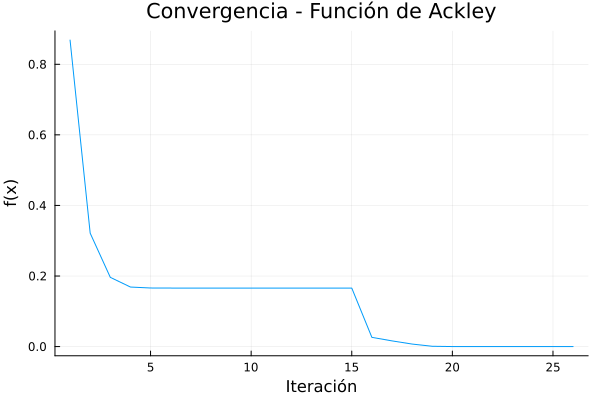

In [263]:
p2 = plot(hist_ackley, title="Convergencia - Función de Ackley", xlabel="Iteración", ylabel="f(x)", legend=false)